<a href="https://colab.research.google.com/github/shashibyadav/Rossman-Sales/blob/main/ConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "My Drive"
!google-drive-ocamlfuse "/content/gdrive/My Drive"

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force&state=i3Xkalx2O4fMhWCDk%2FtN8EER13QrTw4be3B-75qyKoY'
/bin/sh: 1: firefox: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: chromium-browser: not found
/usr/bin/open: 882: www-browser: not found
/usr/bin/open: 882: links2: not found
/usr/bin/open: 882: elinks: not found
/usr/bin/open: 882: links: not found
/usr/bin/open: 882: lynx: not found
/usr/bin/open: 882: w3m: not found
xdg-open: no method available for opening

In [ ]:
base_path = "//content/gdrive/My Drive/Project 2/"
base_path_s = base_path + "Shashi/"
base_path_e = base_path_s +  "Engineered/"

Importing Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import keras
from sklearn.preprocessing import LabelEncoder
from numpy import array, hstack, save
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.inspection import permutation_importance
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.optimizers import Adam

In [ ]:
print(keras.__version__)

2.14.0


In [ ]:
full_data_frame = pd.read_csv(base_path + "Merged_Train_Data.csv", index_col=None)
full_data_frame = full_data_frame.drop(full_data_frame.columns[0], axis=1)
full_data_frame = full_data_frame.sort_values(by="Date")

<ipython-input-4-6c6226dcc421>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data_frame = pd.read_csv(base_path + "Merged_Train_Data.csv", index_col=None)


In [ ]:
full_data_frame.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,StateName,file,Mean_TemperatureC,Events
1017208,1115,2,2013-01-01,0,0,0,0,a,1,2013,...,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",HE,Hessen,Hessen,6,Rain
1016473,379,2,2013-01-01,0,0,0,0,a,1,2013,...,NaN,0,NaN,NaN,NaN,"HB,NI",Niedersachsen,Niedersachsen,6,Rain
1016472,378,2,2013-01-01,0,0,0,0,a,1,2013,...,2012.0,0,NaN,NaN,NaN,NW,NordrheinWestfalen,NordrheinWestfalen,4,Rain
1016471,377,2,2013-01-01,0,0,0,0,a,1,2013,...,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",SH,SchleswigHolstein,SchleswigHolstein,7,Rain
1016470,376,2,2013-01-01,0,0,0,0,a,1,2013,...,2012.0,0,NaN,NaN,NaN,BE,Berlin,Berlin,7,Rain


Preprocessing

In [ ]:
full_data_frame_NA = full_data_frame.dropna().copy()
full_data_frame_NA.reset_index(inplace=True)
full_data_frame_NA.drop("index", axis=1, inplace=True)

In [ ]:
full_data_frame_NA.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,StateName,file,Mean_TemperatureC,Events
0,377,2,2013-01-01,0,0,0,0,a,1,2013,...,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",SH,SchleswigHolstein,SchleswigHolstein,7,Rain
1,375,2,2013-01-01,0,0,0,0,a,1,2013,...,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",ST,SachsenAnhalt,SachsenAnhalt,7,Rain
2,372,2,2013-01-01,0,0,0,0,a,1,2013,...,2010.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct",NW,NordrheinWestfalen,NordrheinWestfalen,4,Rain
3,371,2,2013-01-01,0,0,0,0,a,1,2013,...,2009.0,1,45.0,2014.0,"Feb,May,Aug,Nov",HE,Hessen,Hessen,6,Rain
4,370,2,2013-01-01,0,0,0,0,a,1,2013,...,2000.0,1,31.0,2009.0,"Jan,Apr,Jul,Oct",NW,NordrheinWestfalen,NordrheinWestfalen,4,Rain


In [ ]:
full_data_frame_NA = pd.read_csv(base_path_s + "Merged_Train_Data_NA.csv")

In [ ]:
full_data_frame_NA.to_csv(base_path_s + 'Merged_Train_Data_NA.csv', index=False)

In [ ]:
full_data_frame_NA["Day"] = pd.to_datetime(full_data_frame_NA["Date"]).dt.day

In [ ]:
full_data_frame_NA.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,StateName,file,Mean_TemperatureC,Events,Day
0,377,2,2013-01-01,0,0,0,0,a,1,2013,...,1,18.0,2010.0,"Feb,May,Aug,Nov",SH,SchleswigHolstein,SchleswigHolstein,7,Rain,1
1,375,2,2013-01-01,0,0,0,0,a,1,2013,...,1,37.0,2009.0,"Jan,Apr,Jul,Oct",ST,SachsenAnhalt,SachsenAnhalt,7,Rain,1
2,372,2,2013-01-01,0,0,0,0,a,1,2013,...,1,18.0,2014.0,"Jan,Apr,Jul,Oct",NW,NordrheinWestfalen,NordrheinWestfalen,4,Rain,1
3,371,2,2013-01-01,0,0,0,0,a,1,2013,...,1,45.0,2014.0,"Feb,May,Aug,Nov",HE,Hessen,Hessen,6,Rain,1
4,370,2,2013-01-01,0,0,0,0,a,1,2013,...,1,31.0,2009.0,"Jan,Apr,Jul,Oct",NW,NordrheinWestfalen,NordrheinWestfalen,4,Rain,1


In [ ]:
len(full_data_frame_NA)

247462

In [ ]:
full_data_frame_NA["StateHoliday"].unique()

array(['a', '0', 'b', 'c'], dtype=object)

In [ ]:
full_data_frame_NA["Sales"].unique()

array([    0,  7296,  5462, ..., 15112, 11972, 15894])

In [ ]:
full_data_frame_NA.drop(columns=["StateName","file","Date_Month","Date"], inplace=True)

In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['StateHoliday'] = label_encoder.fit_transform(full_data_frame_NA['StateHoliday'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'0': 0, 'a': 1, 'b': 2, 'c': 3}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['State'] = label_encoder.fit_transform(full_data_frame_NA['State'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'BW': 0, 'BY': 1, 'HE': 2, 'HH': 3, 'NW': 4, 'RP': 5, 'SH': 6, 'SN': 7, 'ST': 8, 'TH': 9}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['Events'] = label_encoder.fit_transform(full_data_frame_NA['Events'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'Fog': 0, 'Fog-Rain': 1, 'Fog-Rain-Hail': 2, 'Fog-Rain-Hail-Thunderstorm': 3, 'Fog-Rain-Snow': 4, 'Fog-Rain-Snow-Hail': 5, 'Fog-Rain-Thunderstorm': 6, 'Fog-Snow': 7, 'Fog-Snow-Hail': 8, 'Fog-Thunderstorm': 9, 'Rain': 10, 'Rain-Hail': 11, 'Rain-Hail-Thunderstorm': 12, 'Rain-Snow': 13, 'Rain-Snow-Hail': 14, 'Rain-Snow-Hail-Thunderstorm': 15, 'Rain-Snow-Thunderstorm': 16, 'Rain-Thunderstorm': 17, 'Snow': 18, 'Snow-Hail': 19, 'Thunderstorm': 20}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['PromoInterval'] = label_encoder.fit_transform(full_data_frame_NA['PromoInterval'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'Feb,May,Aug,Nov': 0, 'Jan,Apr,Jul,Oct': 1, 'Mar,Jun,Sept,Dec': 2}


One hot encoding for Store Type

In [ ]:
one_hot_encoded = pd.get_dummies(full_data_frame_NA['StoreType'], prefix='StoreType')
full_data_frame_NA = pd.concat([full_data_frame_NA, one_hot_encoded], axis=1)
full_data_frame_NA = full_data_frame_NA.drop('StoreType', axis=1)

In [ ]:
one_hot_encoded.head()

,StoreType_a,StoreType_c,StoreType_d
0,1,0,0
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [ ]:
full_data_frame_NA['StoreType_a'] = full_data_frame_NA['StoreType_a'].astype(np.int64)
full_data_frame_NA['StoreType_c'] = full_data_frame_NA['StoreType_c'].astype(np.int64)
full_data_frame_NA['StoreType_d'] = full_data_frame_NA['StoreType_d'].astype(np.int64)

label encoding for Store type

In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['StoreType'] = label_encoder.fit_transform(full_data_frame_NA['StoreType'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'a': 0, 'c': 1, 'd': 2}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['Assortment'] = label_encoder.fit_transform(full_data_frame_NA['Assortment'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'a': 0, 'c': 1}


In [ ]:
full_data_frame_NA = pd.read_csv(base_path_s + "Prepocessed_Train_Data_NA.csv")

In [ ]:
full_data_frame_NA.to_csv(base_path_s + 'Prepocessed_Train_Data_NA.csv', index=False)

In [ ]:
features = ["Store","DayOfWeek","Customers","Open",
            "Promo","StateHoliday","SchoolHoliday",
            "Year","Month","StoreType_a","StoreType_c","StoreType_d","Assortment",
            "CompetitionDistance","CompetitionOpenSinceMonth",
            "CompetitionOpenSinceYear","Promo2","Promo2SinceWeek",
            "PromoInterval","State","Mean_TemperatureC","Events","Day"]
results = ["Sales"]

In [ ]:
full_data_frame_NA.dtypes

Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                   int64
SchoolHoliday                  int64
Year                           int64
Month                          int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
State                          int64
Mean_TemperatureC              int64
Events                         int64
Day                            int64
StoreType_a                    int64
StoreType_c                    int64
StoreType_d                    int64
dtype: object

In [ ]:
store_wise_data = {}
for item in full_data_frame_NA["Store"].unique():
  store_wise_data[item] = full_data_frame_NA[full_data_frame_NA["Store"] == item].copy()
  store_wise_data[item].reset_index(inplace=True)
  store_wise_data[item].drop('index', axis=1, inplace=True)

feature engineering Total Sales per day

In [ ]:
full_data_frame_NA['TotalSales'] = full_data_frame_NA.groupby(["Year","Month","Day","Store"])['Sales'].transform('sum')

In [ ]:
model_train = store_wise_data[377].copy()

In [ ]:
model_train = full_data_frame_NA.copy()

Spliting using numpy

In [ ]:
window_size = 7

In [ ]:
X = full_data_frame_NA[features].to_numpy()
y = full_data_frame_NA[results].to_numpy()

In [ ]:
num_windows = len(full_data_frame_NA) - window_size + 1

In [ ]:
X = array([X[i:i+window_size, :] for i in range(num_windows)])

In [ ]:
y = y[window_size-1:]

In [ ]:
X.shape

(247456, 7, 23)

In [ ]:
y.shape

(247456, 1)

From engineered

In [ ]:
!pip install pyarrow

In [ ]:
import pyarrow.feather as feather

In [ ]:
full_data_frame_NA = feather.read_feather(base_path_e + 'train_cleanf')

In [ ]:
full_data_frame_NA.drop(['index'], axis=1, inplace=True)

In [ ]:
full_data_frame_NA['StoreType'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [ ]:
one_hot_encoded = pd.get_dummies(full_data_frame_NA['StoreType'], prefix='StoreType')
full_data_frame_NA = pd.concat([full_data_frame_NA, one_hot_encoded], axis=1)
full_data_frame_NA = full_data_frame_NA.drop('StoreType', axis=1)

In [ ]:
full_data_frame_NA['Assortment'].unique()

array(['a', 'c', 'b'], dtype=object)

In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['Assortment'] = label_encoder.fit_transform(full_data_frame_NA['Assortment'])
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'a': 0, 'b': 1, 'c': 2}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['PromoInterval'] = label_encoder.fit_transform(full_data_frame_NA['PromoInterval'])
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'Feb,May,Aug,Nov': 0, 'Jan,Apr,Jul,Oct': 1, 'Mar,Jun,Sept,Dec': 2, None: 3}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['State'] = label_encoder.fit_transform(full_data_frame_NA['State'])
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'BE': 0, 'BW': 1, 'BY': 2, 'HB,NI': 3, 'HE': 4, 'HH': 5, 'NW': 6, 'RP': 7, 'SH': 8, 'SN': 9, 'ST': 10, 'TH': 11}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['file'] = label_encoder.fit_transform(full_data_frame_NA['file'])
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'Rossmann_DE_BE': 0, 'Rossmann_DE_BW': 1, 'Rossmann_DE_BY': 2, 'Rossmann_DE_HE': 3, 'Rossmann_DE_HH': 4, 'Rossmann_DE_NI': 5, 'Rossmann_DE_NW': 6, 'Rossmann_DE_RP': 7, 'Rossmann_DE_SH': 8, 'Rossmann_DE_SN': 9, 'Rossmann_DE_ST': 10, 'Rossmann_DE_TH': 11}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['week'] = label_encoder.fit_transform(full_data_frame_NA['week'])
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'2013-01-06 - 2013-01-12': 0, '2013-01-13 - 2013-01-19': 1, '2013-01-20 - 2013-01-26': 2, '2013-01-27 - 2013-02-02': 3, '2013-02-03 - 2013-02-09': 4, '2013-02-10 - 2013-02-16': 5, '2013-02-17 - 2013-02-23': 6, '2013-02-24 - 2013-03-02': 7, '2013-03-03 - 2013-03-09': 8, '2013-03-10 - 2013-03-16': 9, '2013-03-17 - 2013-03-23': 10, '2013-03-24 - 2013-03-30': 11, '2013-03-31 - 2013-04-06': 12, '2013-04-07 - 2013-04-13': 13, '2013-04-14 - 2013-04-20': 14, '2013-04-21 - 2013-04-27': 15, '2013-04-28 - 2013-05-04': 16, '2013-05-05 - 2013-05-11': 17, '2013-05-12 - 2013-05-18': 18, '2013-05-19 - 2013-05-25': 19, '2013-05-26 - 2013-06-01': 20, '2013-06-02 - 2013-06-08': 21, '2013-06-09 - 2013-06-15': 22, '2013-06-16 - 2013-06-22': 23, '2013-06-23 - 2013-06-29': 24, '2013-06-30 - 2013-07-06': 25, '2013-07-07 - 2013-07-13': 26, '2013-07-14 - 2013-07-20': 27, '2013-07-21 - 2013-07-27': 28, '2013-07-28 - 2013-08-03': 29, '2013-08-04 - 2013-08-10': 30, '2013-08-11 - 2013-08-17': 31, '2013-08-18 - 201

In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['Events'] = label_encoder.fit_transform(full_data_frame_NA['Events'])
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'Fog': 0, 'Fog-Rain': 1, 'Fog-Rain-Hail': 2, 'Fog-Rain-Hail-Thunderstorm': 3, 'Fog-Rain-Snow': 4, 'Fog-Rain-Snow-Hail': 5, 'Fog-Rain-Thunderstorm': 6, 'Fog-Snow': 7, 'Fog-Snow-Hail': 8, 'Fog-Thunderstorm': 9, 'Rain': 10, 'Rain-Hail': 11, 'Rain-Hail-Thunderstorm': 12, 'Rain-Snow': 13, 'Rain-Snow-Hail': 14, 'Rain-Snow-Hail-Thunderstorm': 15, 'Rain-Snow-Thunderstorm': 16, 'Rain-Thunderstorm': 17, 'Snow': 18, 'Snow-Hail': 19, 'Thunderstorm': 20, None: 21}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['StateName'] = label_encoder.fit_transform(full_data_frame_NA['StateName'])
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'BadenWuerttemberg': 0, 'Bayern': 1, 'Berlin': 2, 'Hamburg': 3, 'Hessen': 4, 'Niedersachsen': 5, 'NordrheinWestfalen': 6, 'RheinlandPfalz': 7, 'Sachsen': 8, 'SachsenAnhalt': 9, 'SchleswigHolstein': 10, 'Thueringen': 11}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['file_DE'] = label_encoder.fit_transform(full_data_frame_NA['file_DE'])
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'Rossmann_DE': 0}


In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['week_DE'] = label_encoder.fit_transform(full_data_frame_NA['week_DE'])
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'2013-01-06 - 2013-01-12': 0, '2013-01-13 - 2013-01-19': 1, '2013-01-20 - 2013-01-26': 2, '2013-01-27 - 2013-02-02': 3, '2013-02-03 - 2013-02-09': 4, '2013-02-10 - 2013-02-16': 5, '2013-02-17 - 2013-02-23': 6, '2013-02-24 - 2013-03-02': 7, '2013-03-03 - 2013-03-09': 8, '2013-03-10 - 2013-03-16': 9, '2013-03-17 - 2013-03-23': 10, '2013-03-24 - 2013-03-30': 11, '2013-03-31 - 2013-04-06': 12, '2013-04-07 - 2013-04-13': 13, '2013-04-14 - 2013-04-20': 14, '2013-04-21 - 2013-04-27': 15, '2013-04-28 - 2013-05-04': 16, '2013-05-05 - 2013-05-11': 17, '2013-05-12 - 2013-05-18': 18, '2013-05-19 - 2013-05-25': 19, '2013-05-26 - 2013-06-01': 20, '2013-06-02 - 2013-06-08': 21, '2013-06-09 - 2013-06-15': 22, '2013-06-16 - 2013-06-22': 23, '2013-06-23 - 2013-06-29': 24, '2013-06-30 - 2013-07-06': 25, '2013-07-07 - 2013-07-13': 26, '2013-07-14 - 2013-07-20': 27, '2013-07-21 - 2013-07-27': 28, '2013-07-28 - 2013-08-03': 29, '2013-08-04 - 2013-08-10': 30, '2013-08-11 - 2013-08-17': 31, '2013-08-18 - 201

In [ ]:
label_encoder = LabelEncoder()
full_data_frame_NA['State_DE'] = label_encoder.fit_transform(full_data_frame_NA['State_DE'])
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{None: 0}


In [ ]:
full_data_frame_NA.dtypes

Store                                  int64
DayOfWeek                              int64
Date                          datetime64[ns]
Sales                                  int64
Customers                              int64
Open                                   int64
Promo                                  int64
StateHoliday                            bool
SchoolHoliday                          int64
Year                                   int64
Month                                  int64
Week                                   int64
Day                                    int64
Dayofweek                              int64
Dayofyear                              int64
Is_month_end                            bool
Is_month_start                          bool
Is_quarter_end                          bool
Is_quarter_start                        bool
Is_year_end                             bool
Is_year_start                           bool
Elapsed                                int64
Assortment

In [ ]:
features = ["Store","DayOfWeek","Customers","Open","Is_month_end","Is_month_start","Is_quarter_end","Is_quarter_start","Is_year_end","Is_year_start",
            "Promo","StateHoliday","SchoolHoliday","Dayofyear","Elapsed","Promo2SinceYear","Max_TemperatureC","Mean_TemperatureC","Min_TemperatureC","Dew_PointC",
            "Year","Month","StoreType_a","StoreType_b","StoreType_c","StoreType_d","Assortment","MeanDew_PointC","Min_DewpointC","Max_Humidity","Mean_Humidity",
            "CompetitionDistance","CompetitionOpenSinceMonth","Min_Humidity","Max_Sea_Level_PressurehPa","Mean_Sea_Level_PressurehPa","Min_Sea_Level_PressurehPa",
            "CompetitionOpenSinceYear","Promo2","Promo2SinceWeek","Max_VisibilityKm","Mean_VisibilityKm","Min_VisibilitykM","Max_Wind_SpeedKm_h","Mean_Wind_SpeedKm_h",
            "PromoInterval","State","Mean_TemperatureC","Events","Day","Max_Gust_SpeedKm_h","Precipitationmm","CloudCover","WindDirDegrees","AfterSchoolHoliday",
            "BeforeSchoolHoliday","AfterStateHoliday","BeforeStateHoliday","AfterPromo","BeforePromo","SchoolHoliday_bw","StateHoliday_bw","Promo_bw","SchoolHoliday_fw",
            "StateHoliday_fw","Promo_fw"]
results = ["Sales"]

In [ ]:
full_data_frame_NA.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw,StoreType_a,StoreType_b,StoreType_c,StoreType_d
0,1097,2,2013-01-01,5961,1405,1,0,True,1,2013,...,1.0,1.0,0.0,4.0,1.0,1.0,0,1,0,0
1,948,2,2013-01-01,4491,1039,1,0,True,1,2013,...,1.0,1.0,0.0,4.0,2.0,1.0,0,1,0,0
2,512,2,2013-01-01,2646,625,1,0,True,1,2013,...,1.0,1.0,0.0,4.0,2.0,1.0,0,1,0,0
3,769,2,2013-01-01,5035,1248,1,0,True,1,2013,...,1.0,1.0,0.0,4.0,1.0,1.0,0,1,0,0
4,733,2,2013-01-01,10765,2377,1,0,True,1,2013,...,1.0,1.0,0.0,4.0,1.0,1.0,0,1,0,0


In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
full_data_frame_NA['Date'] = pd.to_datetime(full_data_frame_NA['Date'])

In [ ]:
full_data_frame_NA = full_data_frame_NA.sort_values(by='Date', ascending=True)
full_data_frame_NA.reset_index(inplace=True)
full_data_frame_NA.drop(['index'], axis=1, inplace=True)

In [ ]:
full_data_frame_NA.to_csv(base_path_e + 'engineered.csv')

In [ ]:
full_data_frame_NA = pd.read_csv(base_path_e + 'engineered.csv')

In [ ]:
len(full_data_frame_NA)

844338

In [ ]:
full_data_frame_NA.dropna(axis=0, inplace=True)

In [ ]:
len(full_data_frame_NA)

185462

In [ ]:
full_data_frame_NA.to_csv(base_path_e + 'engineered_NA_dropped.csv')

In [ ]:
full_data_frame_NA = pd.read_csv(base_path_e + 'engineered_NA_dropped.csv')

In [ ]:
full_data_frame_NA = None

In [ ]:
window_size = 7

In [ ]:
full_data_frame_NA[features].dtypes

Store                           int64
DayOfWeek                       int64
Customers                       int64
Open                            int64
Is_month_end                    int64
Is_month_start                  int64
Is_quarter_end                  int64
Is_quarter_start                int64
Is_year_end                     int64
Is_year_start                   int64
Promo                           int64
StateHoliday                    int64
SchoolHoliday                   int64
Dayofyear                       int64
Elapsed                         int64
Promo2SinceYear                 int64
Max_TemperatureC                int64
Mean_TemperatureC               int64
Min_TemperatureC                int64
Dew_PointC                      int64
Year                            int64
Month                           int64
StoreType_a                     int64
StoreType_b                     int64
StoreType_c                     int64
StoreType_d                     int64
Assortment  

In [ ]:
full_data_frame_NA["Is_month_end"] = full_data_frame_NA["Is_month_end"].astype(np.int64)
full_data_frame_NA["Is_month_start"] = full_data_frame_NA["Is_month_start"].astype(np.int64)
full_data_frame_NA["Is_quarter_end"] = full_data_frame_NA["Is_quarter_end"].astype(np.int64)
full_data_frame_NA["Is_quarter_start"] = full_data_frame_NA["Is_quarter_start"].astype(np.int64)
full_data_frame_NA["Is_year_end"] = full_data_frame_NA["Is_year_end"].astype(np.int64)
full_data_frame_NA["Is_year_start"] = full_data_frame_NA["Is_year_start"].astype(np.int64)
full_data_frame_NA["StateHoliday"] = full_data_frame_NA["StateHoliday"].astype(np.int64)

In [ ]:
X = full_data_frame_NA[features].to_numpy()
y = full_data_frame_NA[results].to_numpy()

In [ ]:
np.save(base_path_e + 'X_data_NA.npy', X)

In [ ]:
np.save(base_path_e + 'y_data_NA.npy', y)

In [ ]:
X = np.load(base_path_e + 'X_data_NA.npy', allow_pickle=True)
y = np.load(base_path_e + 'y_data_NA.npy', allow_pickle=True)

In [ ]:
half = int(len(X)/2)
half

92731

In [ ]:
np.save(base_path_e + 'X_data_first_half_NA.npy', X[:half])
np.save(base_path_e + 'y_data_first_half_NA.npy', y[:half])
np.save(base_path_e + 'X_data_second_half_NA.npy', X[half:])
np.save(base_path_e + 'y_data_second_half_NA.npy', y[half:])

In [ ]:
X = np.load(base_path_e + 'X_data_first_half_NA.npy', allow_pickle=True)
y = np.load(base_path_e + 'y_data_first_half_NA.npy', allow_pickle=True)

In [ ]:
num_windows = len(X) - window_size + 1

In [ ]:
X = array([X[i:i+window_size, :] for i in range(num_windows)])

In [ ]:
y = y[window_size-1:]

In [ ]:
X[0][0]

array([ 1.0970000e+03,  2.0000000e+00,  1.4050000e+03,  1.0000000e+00,
        0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
        0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
        1.0000000e+00,  1.0000000e+00,  1.3569984e+09,  1.9000000e+03,
        8.0000000e+00,  6.0000000e+00,  4.0000000e+00,  7.0000000e+00,
        2.0130000e+03,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  3.0000000e+00,
        1.0000000e+00,  9.2000000e+01,  7.5000000e+01,  7.2000000e+02,
        3.0000000e+00,  5.9000000e+01,  1.0150000e+03,  1.0100000e+03,
        1.0080000e+03,  2.0020000e+03,  0.0000000e+00,  1.0000000e+00,
        3.1000000e+01,  1.9000000e+01,  5.0000000e+00,  2.6000000e+01,
        1.9000000e+01,  3.0000000e+00,  7.0000000e+00,  6.0000000e+00,
        1.0000000e+01,  1.0000000e+00,            nan,  2.5000000e-01,
        8.0000000e+00, -1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
      

In [ ]:
X.shape

(247456, 7, 23)

In [ ]:
y.shape

(247456, 1)

Training

In [ ]:
n_features = X.shape[2]
n_features

23

In [ ]:
print(len(X),len(y))

247456 247456


In [ ]:
testPer = int(len(X) * 0.99)
testX = X[testPer:]
testY = y[testPer:]
X = X[:testPer]
y = y[:testPer]
# trainX = X
# trainY = y
trainPer = int(len(X) * 0.9)
trainX = X[:trainPer]
trainY = y[:trainPer]
predictX = X[trainPer:]
predictY = y[trainPer:]

In [ ]:
print(len(trainX),len(predictX),len(testX),len(trainY),len(predictY),len(testY))

220482 24499 2475 220482 24499 2475


In [ ]:
X.shape

(244981, 7, 23)

LSTM

In [ ]:
from keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
    initial_lr = 0.01  # Initial learning rate
    decay_factor = 0.1  # Decay factor
    decay_epochs = 300   # Number of epochs after which to decay the learning rate

    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
    return lr

# Create a LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_schedule)

In [ ]:
# define model
optimizer = Adam(learning_rate=0.01)
model = Sequential()
model.add(Dense(n_features))
model.add(LSTM(50, activation='relu', input_shape=(window_size, n_features)))
model.add(Dense(20))
model.add(Dense(10))
model.add(Dense(1, activation='relu'))
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

In [ ]:
print(trainX.shape,trainY.shape,predictX.shape,predictY.shape)

(220482, 7, 23) (220482, 1) (24499, 7, 23) (24499, 1)


In [ ]:
# history = model.fit(trainX, trainY, epochs=800, batch_size=102400, verbose=2)
history = model.fit(trainX, trainY, epochs=800, batch_size=102400, validation_data=(predictX, predictY), callbacks=[lr_callback], verbose=2)

Epoch 1/800
3/3 - 3s - loss: 31495508.0000 - mse: 31495508.0000 - val_loss: 13922017.0000 - val_mse: 13922017.0000 - lr: 0.0100 - 3s/epoch - 1s/step
Epoch 2/800
3/3 - 0s - loss: 12152363.0000 - mse: 12152363.0000 - val_loss: 9941241.0000 - val_mse: 9941241.0000 - lr: 0.0100 - 440ms/epoch - 147ms/step
Epoch 3/800
3/3 - 0s - loss: 10915842.0000 - mse: 10915842.0000 - val_loss: 9967954.0000 - val_mse: 9967954.0000 - lr: 0.0100 - 421ms/epoch - 140ms/step
Epoch 4/800
3/3 - 0s - loss: 10958917.0000 - mse: 10958917.0000 - val_loss: 10837482.0000 - val_mse: 10837482.0000 - lr: 0.0100 - 443ms/epoch - 148ms/step
Epoch 5/800
3/3 - 0s - loss: 10822342.0000 - mse: 10822342.0000 - val_loss: 10097767.0000 - val_mse: 10097767.0000 - lr: 0.0100 - 465ms/epoch - 155ms/step
Epoch 6/800
3/3 - 0s - loss: 9786165.0000 - mse: 9786165.0000 - val_loss: 8918922.0000 - val_mse: 8918922.0000 - lr: 0.0100 - 433ms/epoch - 144ms/step
Epoch 7/800
3/3 - 0s - loss: 8590688.0000 - mse: 8590688.0000 - val_loss: 7881310.50

In [ ]:
dump(model, base_path_s + 'stores_sales_LSTM_model_val_relu.joblib')

['//content/gdrive/My Drive/Project 2/Shashi/stores_sales_LSTM_model_val_relu.joblib']

In [ ]:
model = load(base_path_s + 'stores_sales_LSTM_model_val_relu.joblib')

In [ ]:
yhat = model.predict(testX, verbose=0)

In [ ]:
yhat.shape

(2475, 1)

In [ ]:
sqrt(mean_squared_error(testY, yhat))

1344.6694921200299

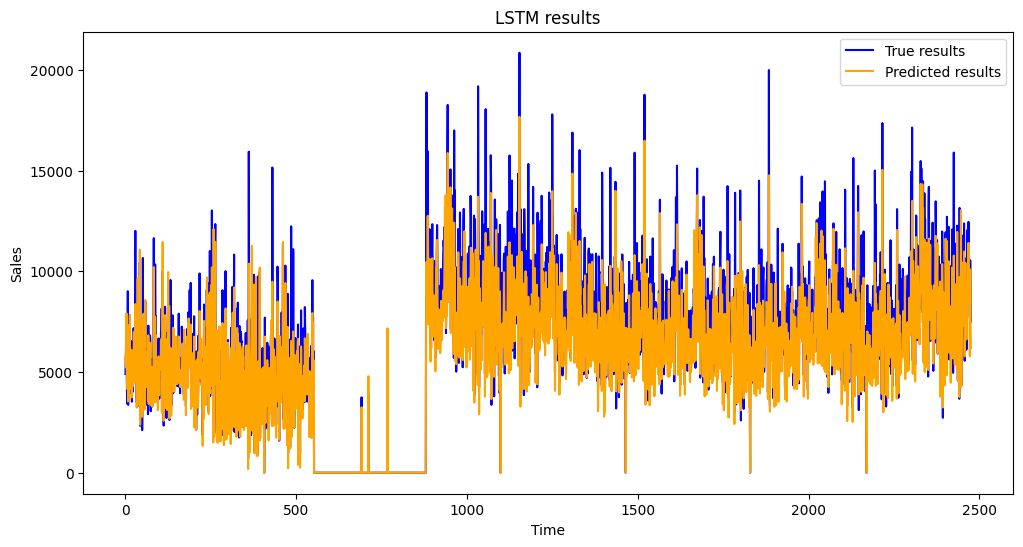

In [ ]:
# Plotting the first array (y1) in blue
plt.figure(figsize=(12, 6))
plt.plot(range(1,len(testY) + 1), testY.flatten(), color='blue', label='True results')

# Plotting the second array (y2) in green
plt.plot(range(1,len(yhat)+ 1), yhat.flatten(), color='orange', label='Predicted results')
# Adding labels and a legend
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('LSTM results')
plt.legend()
# plt.savefig(base_path_s + "stores_LSTM_relu.png")

# Display the plot
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

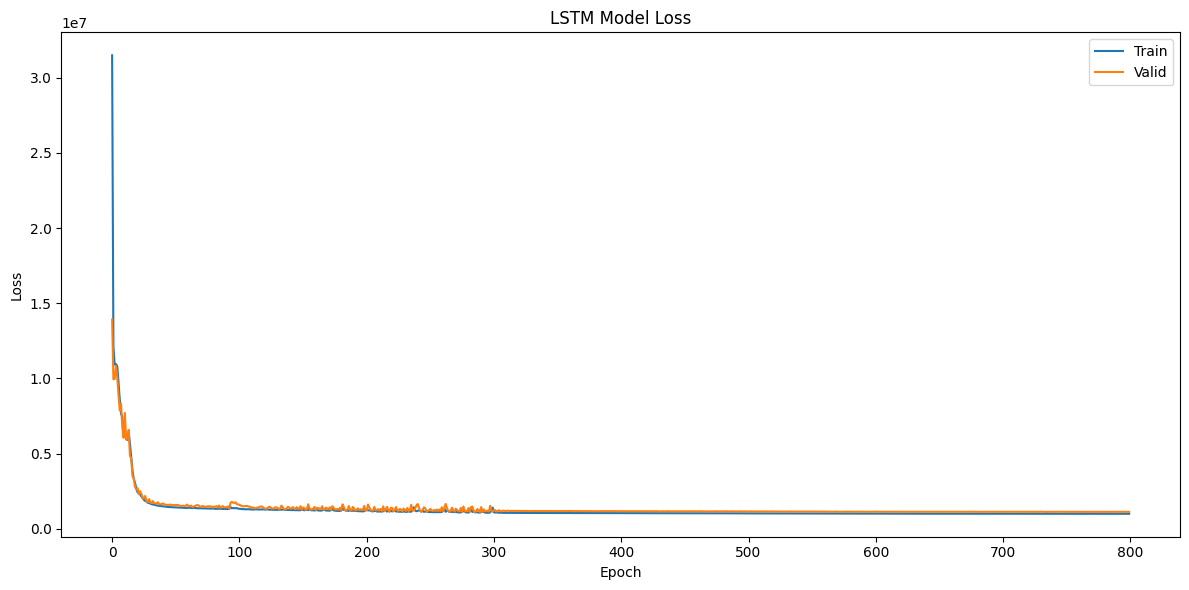

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
# plt.subplot(1, 2, 1)
# plt.plot(history.history['mse'])
# plt.plot(history.history['val_mse'])
# plt.title('LSTM Model MSE')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
# plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'], loc='upper right')

plt.tight_layout()
plt.savefig(base_path_s + "stores_LSTM_Training_relu.png")
plt.show()

CNN model

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, n_features)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50))
model_cnn.add(Dense(1, activation='relu'))
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
history_cnn = model_cnn.fit(trainX, trainY, epochs=800, batch_size=102400, validation_data=(predictX, predictY), verbose=2)

Epoch 1/800
3/3 - 1s - loss: 38521036.0000 - mse: 38521032.0000 - val_loss: 26053274.0000 - val_mse: 26053274.0000 - 1s/epoch - 470ms/step
Epoch 2/800
3/3 - 0s - loss: 22102410.0000 - mse: 22102412.0000 - val_loss: 16631742.0000 - val_mse: 16631742.0000 - 271ms/epoch - 90ms/step
Epoch 3/800
3/3 - 0s - loss: 16265891.0000 - mse: 16265891.0000 - val_loss: 18769500.0000 - val_mse: 18769500.0000 - 271ms/epoch - 90ms/step
Epoch 4/800
3/3 - 0s - loss: 18906316.0000 - mse: 18906316.0000 - val_loss: 18208322.0000 - val_mse: 18208322.0000 - 278ms/epoch - 93ms/step
Epoch 5/800
3/3 - 0s - loss: 17418728.0000 - mse: 17418728.0000 - val_loss: 15215768.0000 - val_mse: 15215768.0000 - 267ms/epoch - 89ms/step
Epoch 6/800
3/3 - 0s - loss: 14376988.0000 - mse: 14376988.0000 - val_loss: 14076394.0000 - val_mse: 14076394.0000 - 265ms/epoch - 88ms/step
Epoch 7/800
3/3 - 0s - loss: 13367710.0000 - mse: 13367710.0000 - val_loss: 14115420.0000 - val_mse: 14115420.0000 - 276ms/epoch - 92ms/step
Epoch 8/800
3/3

In [ ]:
dump(model_cnn, base_path_s + 'stores_sales_CNN_model_val_relu.joblib')

['//content/gdrive/My Drive/Project 2/Shashi/stores_sales_CNN_model_val_relu.joblib']

In [ ]:
model_cnn = load(base_path_s + 'stores_sales_CNN_model_val_relu.joblib')

In [ ]:
yhat_cnn = model_cnn.predict(testX, verbose=0)

In [ ]:
sqrt(mean_squared_error(testY, yhat_cnn))

1424.7451969300475

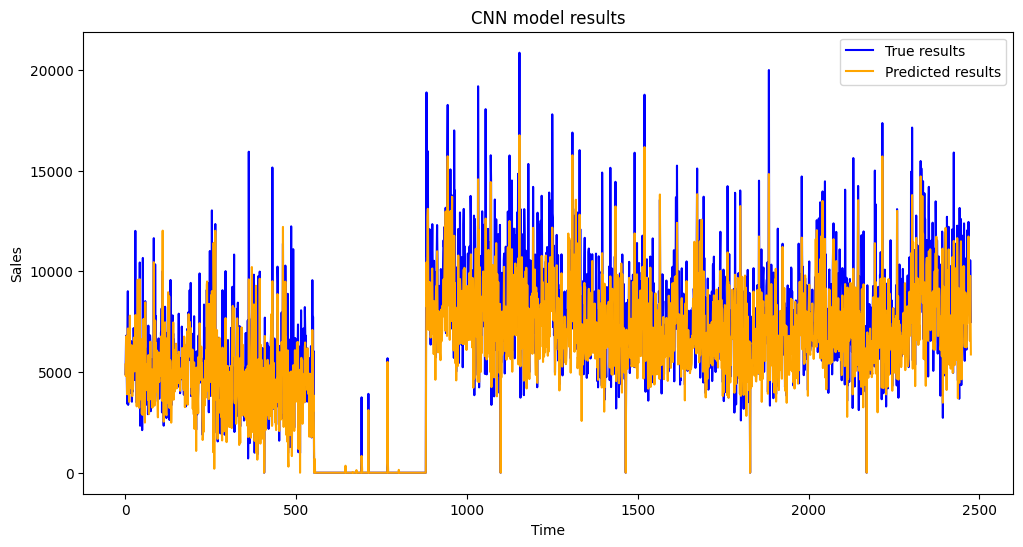

In [ ]:
# Plotting the first array (y1) in blue
plt.figure(figsize=(12, 6))
plt.plot(range(1,len(testY) + 1), testY.flatten(), color='blue', label='True results')

# Plotting the second array (y2) in green
plt.plot(range(1,len(yhat_cnn)+ 1), yhat_cnn.flatten(), color='orange', label='Predicted results')

# Adding labels and a legend
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('CNN model results')
plt.legend()
plt.savefig(base_path_s + "stores_CNN_relu.png")

# Display the plot
plt.show()

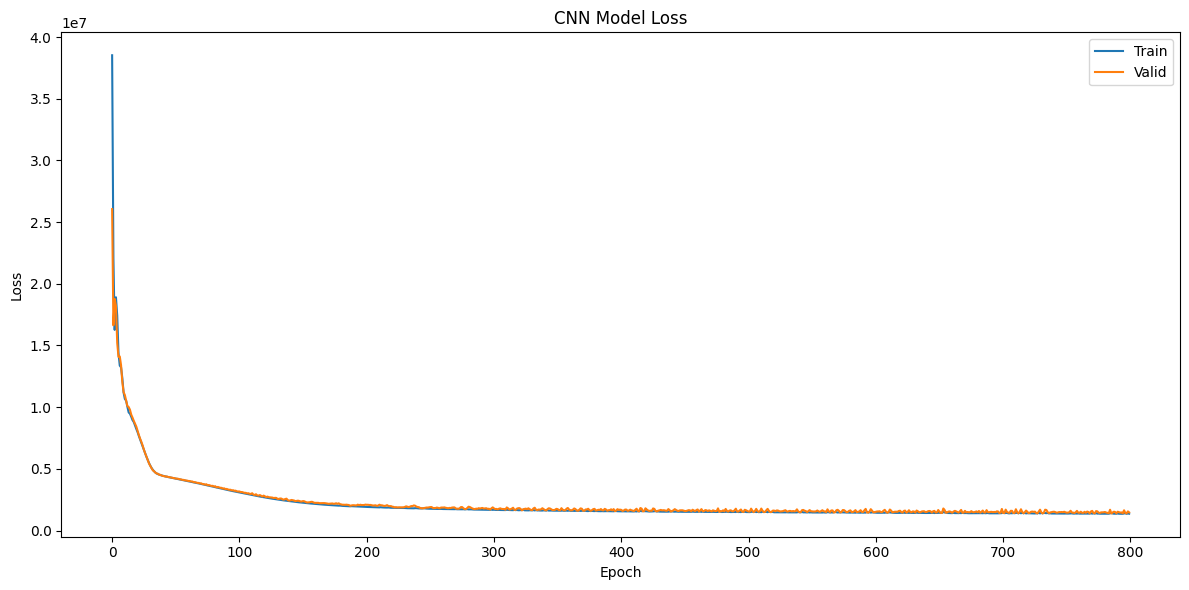

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
# plt.subplot(1, 2, 1)
# plt.plot(history_cnn.history['mse'])
# plt.plot(history_cnn.history['val_mse'])
# plt.title('CNN Model MSE')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend(['Train', 'Test'], loc='upper left')

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'], loc='upper right')

plt.tight_layout()
plt.savefig(base_path_s + "stores_CNN_Training_relu.png")
plt.show()

XGBoost

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [ ]:
train_size = int(len(full_data_frame_NA) * 0.99)
train, test = full_data_frame_NA.iloc[:train_size], full_data_frame_NA.iloc[train_size:]

In [ ]:
X_train, y_train = train[features], train[results]
X_test, y_test = test[features], test[results]

In [ ]:
X = full_data_frame_NA[features].to_numpy()
y = full_data_frame_NA[results].to_numpy()

# testPer = int(len(X) * 0.99)
# testX = X[testPer:]
# testY = y[testPer:]
# X = X[:testPer]
# y = y[:testPer]
# # trainX = X
# # trainY = y
trainPer = int(len(X) * 0.99)
# trainX = X[:trainPer]
# trainY = y[:trainPer]
# predictX = X[trainPer:]
# predictY = y[trainPer:]

X_train = X[:trainPer]
y_train = y[:trainPer]
X_test = X[trainPer:]
y_test = y[trainPer:]

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions, squared = False)
print(f'Mean Squared Error: {mse}')
# Evaluate the model
r2s = r2_score(y_test, predictions)
print(f'R Squared Error: {r2s}')

<ipython-input-75-ec077e2a7fbd>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Mean Squared Error: 521.422372058266
R Squared Error: 0.9793217001699945


KeyError: ignored

<Figure size 2000x1000 with 0 Axes>

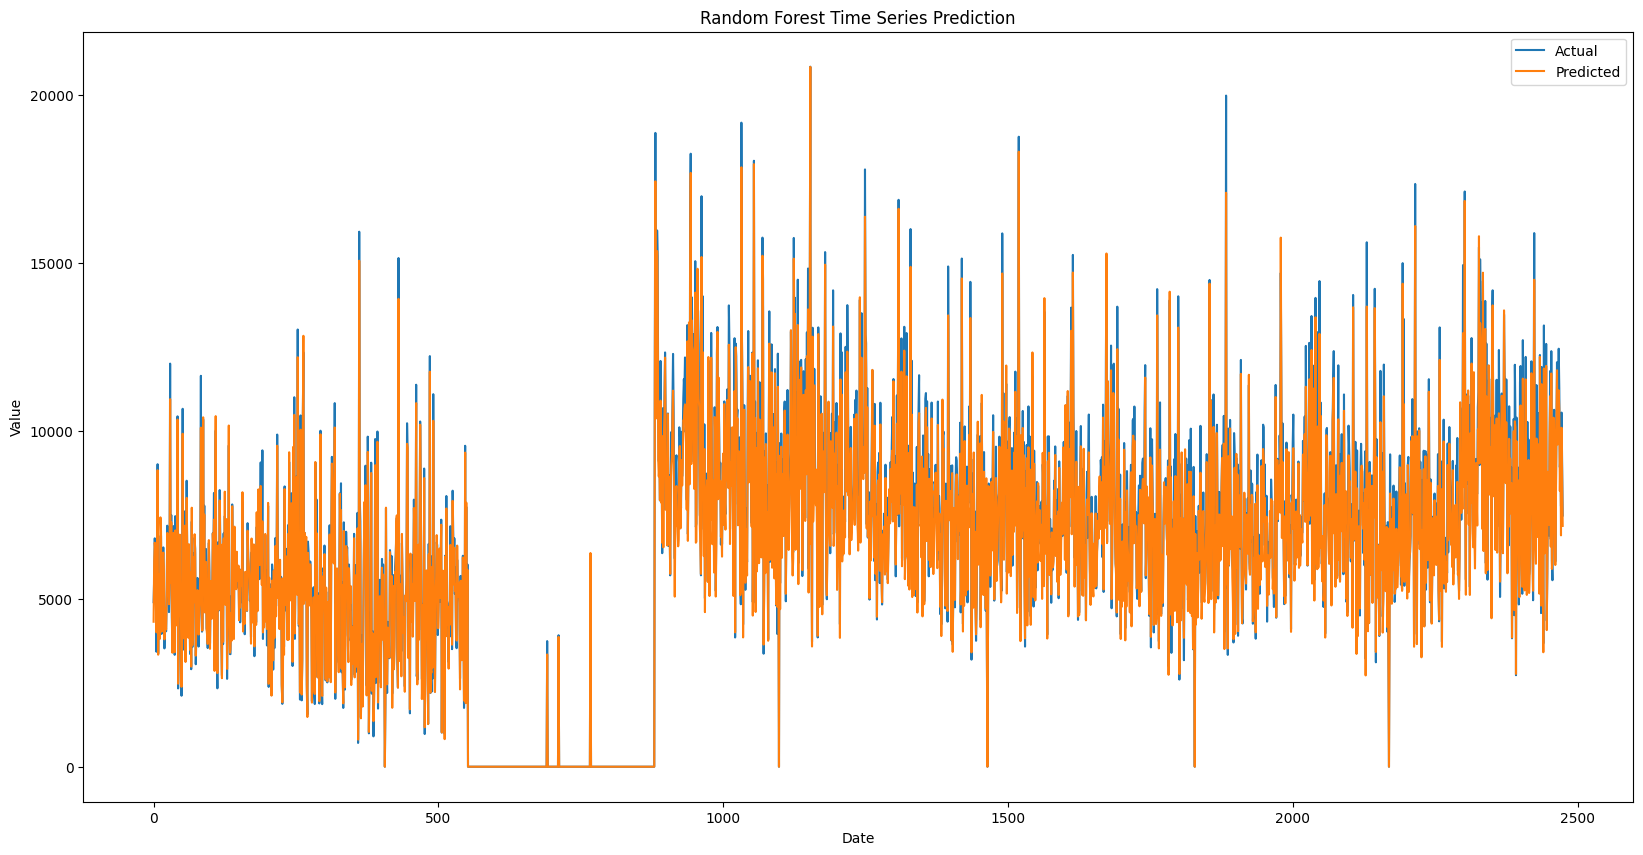

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(range(len(X_test)), y_test, label='Actual')
plt.plot(range(len(X_test)), predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Random Forest Time Series Prediction')
plt.legend()
plt.savefig(base_path_s + "Random Forest.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:33:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: 2473.5145906976095
R Squared Error: 0.534666349878725


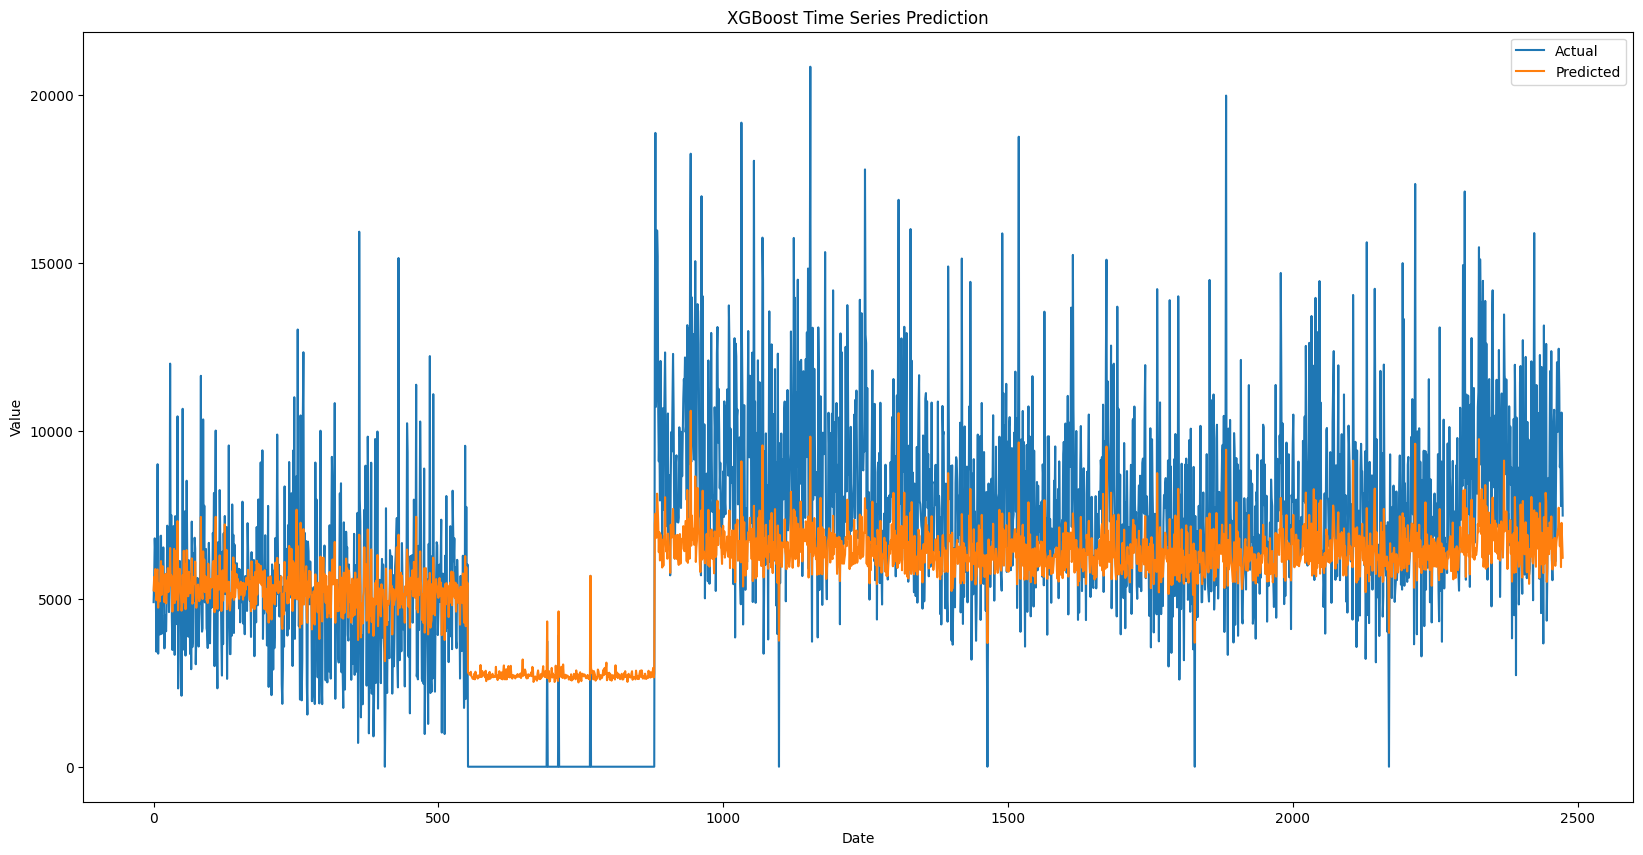

In [ ]:
# Convert data to DMatrix format (required for XGBoost)
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'n_estimators': 100
}

# Train the XGBoost model
xg_reg = xgb.train(params=params, dtrain=train_dmatrix, num_boost_round=10)

# Make predictions on the test set
predictions = xg_reg.predict(test_dmatrix)

# Evaluate the model
mse = mean_squared_error(y_test, predictions, squared = False)
print(f'Mean Squared Error: {mse}')
# Evaluate the model
r2s = r2_score(y_test, predictions)
print(f'R Squared Error: {r2s}')

# Optional: Plot predictions vs. actual values for visualization
plt.figure(figsize=(20, 10))
plt.plot(range(len(X_test)), y_test, label='Actual')
plt.plot(range(len(X_test)), predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('XGBoost Time Series Prediction')
plt.legend()
plt.savefig(base_path_s + "XGBoost_actual.png")
plt.show()

store_type_wise

In [ ]:
store_type_wise_data = {}
for item in full_data_frame_NA["StoreType"].unique():
  store_type_wise_data[item] = full_data_frame_NA[full_data_frame_NA["StoreType"] == item].copy()
  store_type_wise_data[item].reset_index(inplace=True)
  store_type_wise_data[item].drop('index', axis=1, inplace=True)

In [ ]:
len(store_type_wise_data[0])

137026

In [ ]:
full_data_frame_NA['StoreTypeSales'] = full_data_frame_NA.groupby(["Year","Month","Day","StoreType"])['Sales'].transform('sum')

In [ ]:
len(store_type_wise_data[0]["Store"].unique())

200

In [ ]:
len(store_wise_data.keys())

365